# Supervised Model

### Import Libraries

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import tensorflow_datasets as tfds

from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.models import Model
from keras.callbacks import EarlyStopping
from keras import optimizers, losses, activations, models
from keras.layers import Convolution2D, Dense, Input, Flatten, Dropout, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D
from keras import applications
from keras.preprocessing.image import ImageDataGenerator

from sklearn.utils import class_weight

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
train_path = "../OCT2017 /train/"
test_path = "../OCT2017 /test/"
valid_path = "../OCT2017 /val/"

In [3]:
BATCH_SIZE = 64
IMG_SIZE = (224, 224)

### Display images

In [4]:
train_ds = tf.keras.utils.image_dataset_from_directory(valid_path)

Found 32 files belonging to 4 classes.


2022-06-22 17:04:18.734368: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 17:04:18.744969: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 17:04:18.745589: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-06-22 17:04:18.747407: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

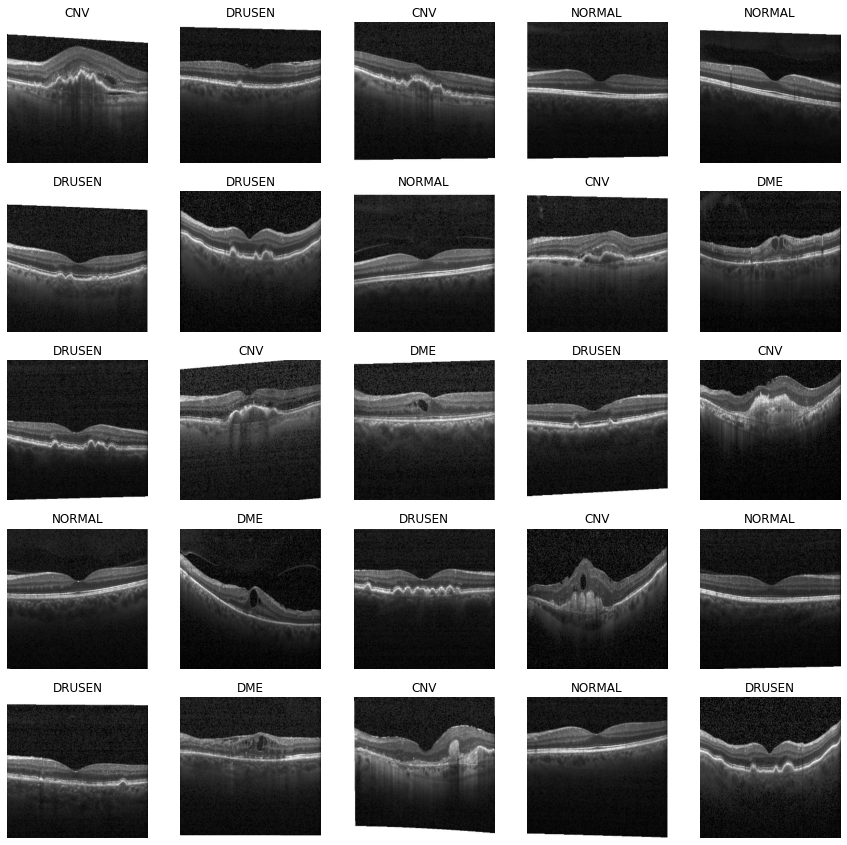

In [5]:
class_names = train_ds.class_names

plt.figure(figsize=(15,15))
for images, labels in train_ds.take(1):
  for i in range(25):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [6]:
train_gen = keras.preprocessing.image.ImageDataGenerator(validation_split = 0.012)
test_gen = keras.preprocessing.image.ImageDataGenerator()

In [7]:
train_batches = train_gen.flow_from_directory(train_path,
                                              target_size = IMG_SIZE,
                                              batch_size = BATCH_SIZE,
                                              subset = 'training',
                                              class_mode = "categorical",
                                              seed = 26)

test_batches = test_gen.flow_from_directory(test_path,
                                            target_size = IMG_SIZE,
                                            batch_size = BATCH_SIZE,
                                            class_mode = "categorical")

valid_batches = train_gen.flow_from_directory(train_path,
                                              target_size = IMG_SIZE,
                                              batch_size = BATCH_SIZE,
                                              subset = 'validation',
                                              class_mode = "categorical",
                                              seed = 26)

Found 82484 images belonging to 4 classes.
Found 968 images belonging to 4 classes.
Found 1000 images belonging to 4 classes.


### VGG16 MODEL 

In [8]:
pretrained_model = tf.keras.applications.vgg16.VGG16(input_shape = (224,224,3),
                                                     include_top = False,
                                                     weights = 'imagenet')

pretrained_model.trainable = False

In [9]:
pretrained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [10]:
model1 = Sequential()
model1.add(pretrained_model)
model1.add(MaxPooling2D())
model1.add(Flatten())
model1.add(Dense(4, activation='softmax'))

In [12]:
vgg16 = model1

optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

vgg16.compile(loss='categorical_crossentropy',
              optimizer= optim,
              metrics=metrics)

vgg16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 max_pooling2d (MaxPooling2D  (None, 3, 3, 512)        0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 4608)              0         
                                                                 
 dense (Dense)               (None, 4)                 18436     
                                                                 
Total params: 14,733,124
Trainable params: 18,436
Non-trainable params: 14,714,688
_________________________________________________________________


In [13]:
epochs = 100

early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                              patience=5)

In [14]:
history = vgg16.fit(train_batches, 
                    validation_data = valid_batches,
                    callbacks = [early_stopping],
                    steps_per_epoch = 825, #82484 training images / 100 epochs
                    epochs = epochs)

Epoch 1/100


2022-06-22 17:04:46.530288: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8200


825/825 [==============================] - 278s 328ms/step - loss: 1.7168 - accuracy: 0.8288 - val_loss: 2.0242 - val_accuracy: 0.8170
Epoch 2/100
825/825 [==============================] - 261s 317ms/step - loss: 1.2649 - accuracy: 0.8726 - val_loss: 1.8671 - val_accuracy: 0.8370
Epoch 3/100
825/825 [==============================] - 263s 318ms/step - loss: 1.1749 - accuracy: 0.8852 - val_loss: 2.4276 - val_accuracy: 0.8600
Epoch 4/100
825/825 [==============================] - 262s 318ms/step - loss: 1.2004 - accuracy: 0.8876 - val_loss: 2.0861 - val_accuracy: 0.8320
Epoch 5/100
825/825 [==============================] - 262s 318ms/step - loss: 1.1088 - accuracy: 0.8942 - val_loss: 1.9212 - val_accuracy: 0.8500
Epoch 6/100
825/825 [==============================] - 261s 317ms/step - loss: 1.1603 - accuracy: 0.8963 - val_loss: 1.4940 - val_accuracy: 0.8640
Epoch 7/100
825/825 [==============================] - 262s 317ms/step - loss: 1.1096 - accuracy: 0.9014 - val_loss: 2.1131 - val_

**89.1% accuracy after 11 epochs.** - results does not vary drastically with 100 epochs with no early stoppage. 

In [15]:
vgg16.evaluate(test_batches)

16/16 [==============================] - 6s 357ms/step - loss: 0.9794 - accuracy: 0.9318


[0.9793604016304016, 0.9318181872367859]

**93.1%** Test Accuracy!

In [16]:
vgg16.save("../Models/vgg16_825steps_062222.h5")

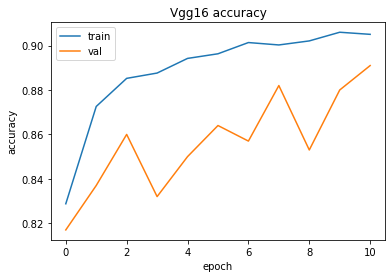

In [17]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Vgg16 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

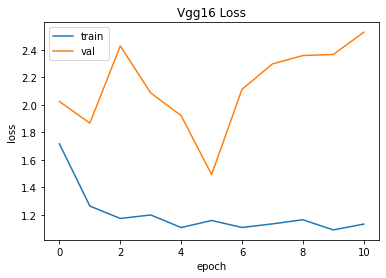

In [18]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Vgg16 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

### InceptionV3 Model

In [19]:
pretrained_model = tf.keras.applications.inception_v3.InceptionV3(input_shape = (224,224,3),
                                                                  include_top = False,
                                                                  weights = 'imagenet')

pretrained_model.trainable = False

In [20]:
pretrained_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 111, 111, 32  96         ['conv2d[0][0]']                 
 alization)                     )                                                      

In [21]:
model2 = Sequential()
model2.add(pretrained_model)
model2.add(MaxPooling2D())
model2.add(Flatten())
model2.add(Dense(4, activation='softmax'))

In [23]:
inception_v3 = model2

optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

inception_v3.compile(loss='categorical_crossentropy',
                    optimizer= optim,
                    metrics=metrics)

inception_v3.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 2, 2, 2048)       0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 8192)              0         
                                                                 
 dense_1 (Dense)             (None, 4)                 32772     
                                                                 
Total params: 21,835,556
Trainable params: 32,772
Non-trainable params: 21,802,784
_________________________________________________________________


In [24]:
epochs = 100

early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                              patience=5)

In [24]:
history = inception_v3.fit(train_batches, validation_data = valid_batches,
                 callbacks = [early_stopping],
                 steps_per_epoch = 825, #82484 training images / 100 epochs
                 epochs = epochs)

Epoch 1/100
825/825 [==============================] - 208s 245ms/step - loss: 7.9302 - accuracy: 0.6064 - val_loss: 6.7225 - val_accuracy: 0.6500
Epoch 2/100
825/825 [==============================] - 200s 242ms/step - loss: 6.5788 - accuracy: 0.6697 - val_loss: 9.8052 - val_accuracy: 0.6690
Epoch 3/100
825/825 [==============================] - 215s 261ms/step - loss: 6.4230 - accuracy: 0.6801 - val_loss: 5.3269 - val_accuracy: 0.7100
Epoch 4/100
825/825 [==============================] - 217s 263ms/step - loss: 5.9050 - accuracy: 0.6944 - val_loss: 5.1900 - val_accuracy: 0.7520
Epoch 5/100
825/825 [==============================] - 194s 235ms/step - loss: 6.4250 - accuracy: 0.6971 - val_loss: 7.2037 - val_accuracy: 0.6260
Epoch 6/100
825/825 [==============================] - 201s 243ms/step - loss: 5.6818 - accuracy: 0.7088 - val_loss: 5.9589 - val_accuracy: 0.6540
Epoch 7/100
825/825 [==============================] - 197s 238ms/step - loss: 6.1727 - accuracy: 0.7069 - val_loss: 6

**75.7%** accuracy after 9 epochs. Similar result when ran 100 epochs with no early stoppage. 

In [25]:
inception_v3.evaluate(test_batches)

16/16 [==============================] - 4s 224ms/step - loss: 8.5422 - accuracy: 0.6767


[8.54219913482666, 0.6766529083251953]

**67.66%** Test accuracy. 

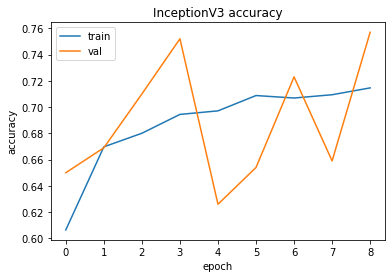

In [26]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('InceptionV3 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

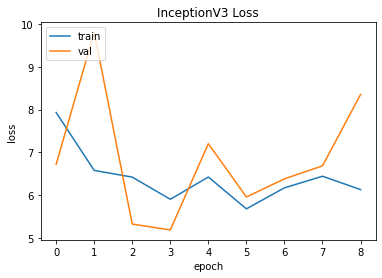

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('InceptionV3 Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [28]:
inception_v3.save("../Models/inceptionv3_825step_062222.h5")

### Resnet50 Model

In [29]:
pretrained_model = tf.keras.applications.resnet50.ResNet50(input_shape = (224,224,3),
                                                                  include_top = False,
                                                                  weights = 'imagenet')

pretrained_model.trainable = False

In [30]:
pretrained_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [31]:
model3 = Sequential()
model3.add(pretrained_model)
model3.add(MaxPooling2D())
model3.add(Flatten())
model3.add(Dense(4, activation='softmax'))

In [32]:
model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 3, 3, 2048)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 4)                 73732     
                                                                 
Total params: 23,661,444
Trainable params: 73,732
Non-trainable params: 23,587,712
_________________________________________________________________


In [33]:
Resnet50 = model3

optim = keras.optimizers.Adam(learning_rate=0.001)
metrics = ["accuracy"]

Resnet50.compile(loss='categorical_crossentropy',
                    optimizer= optim,
                    metrics=metrics)

Resnet50.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 3, 3, 2048)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 18432)             0         
                                                                 
 dense_2 (Dense)             (None, 4)                 73732     
                                                                 
Total params: 23,661,444
Trainable params: 73,732
Non-trainable params: 23,587,712
_________________________________________________________________


In [34]:
epochs = 100

early_stopping = keras.callbacks.EarlyStopping(monitor = "val_loss",
                                              patience=5)

In [35]:
history = Resnet50.fit(train_batches, validation_data = valid_batches,
             callbacks = [early_stopping],
             steps_per_epoch = 825, #82484 training images / 100 epochs
             epochs = epochs)

Epoch 1/100
825/825 [==============================] - 203s 241ms/step - loss: 1.2401 - accuracy: 0.8217 - val_loss: 1.0108 - val_accuracy: 0.8610
Epoch 2/100
825/825 [==============================] - 197s 238ms/step - loss: 0.9586 - accuracy: 0.8717 - val_loss: 0.9436 - val_accuracy: 0.8820
Epoch 3/100
825/825 [==============================] - 195s 236ms/step - loss: 0.8974 - accuracy: 0.8880 - val_loss: 1.5501 - val_accuracy: 0.8770
Epoch 4/100
825/825 [==============================] - 199s 241ms/step - loss: 0.8295 - accuracy: 0.9009 - val_loss: 2.0764 - val_accuracy: 0.8380
Epoch 5/100
825/825 [==============================] - 194s 235ms/step - loss: 0.8266 - accuracy: 0.9048 - val_loss: 1.7433 - val_accuracy: 0.8420
Epoch 6/100
825/825 [==============================] - 193s 233ms/step - loss: 0.8127 - accuracy: 0.9098 - val_loss: 1.6661 - val_accuracy: 0.8860
Epoch 7/100
825/825 [==============================] - 193s 234ms/step - loss: 0.7707 - accuracy: 0.9174 - val_loss: 1

**88.7%** Training accuracy after 7 epochs - Similar result when 100 epochs were ran without early stoppage. 

In [36]:
Resnet50.evaluate(test_batches)

16/16 [==============================] - 4s 217ms/step - loss: 0.2610 - accuracy: 0.9638


[0.26097697019577026, 0.9638429880142212]

**96.4%** Test Accuracy

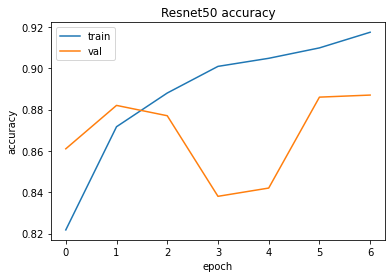

In [37]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Resnet50 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

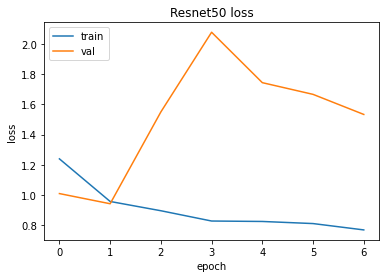

In [38]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Resnet50 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [39]:
Resnet50.save("../Models/Resnet50_825steps_062222.h5")

Resnet50 model achieved the highest accuracy. Fine tuning will be performed on the Resnet50 model.